<a href="https://colab.research.google.com/github/leovcunha/deep_learning_implementations/blob/master/PV_generation_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Photovoltaic panel generation prediction
dataset from https://site.ieee.org/pes-iss/data-sets/#pvge

In this notebook it's analysed data of a PV panel generation from the whole year 2013. Two models of prediction are compared using simple linear regression and Recursive neural networks with LSTM.

#### Step 1 : Load the data files


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
tf.enable_eager_execution()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December' ]
excel_files = [pd.ExcelFile('/content/drive/My Drive/pv2013/PV2013'+month+'.xlsx') for month in month_list]


In [0]:
generation_sheets = [pd.read_excel(file, sheet, header=2, skiprows=[3],  ) for file in excel_files for sheet in file.sheet_names if sheet != 'Info']
generation_data = pd.concat(generation_sheets, sort=False)
  

In [5]:
generation_data.head()

,Unnamed: 0,ExlSolIrr,IntSolIrr,OpTm,TmpAmb C,TmpMdul C,WindVel m/s,E-Total,Fac,Fehler,h-On,h-Total,Iac-Ist,Ipv,Netz-Ein,Pac,Riso,Seriennummer,Status,Uac,Upv-Ist,Upv-Soll,Zac,TimeStamp
0,17:30:00,0.0,0.0,10847.24,-273.17,19.41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,17:35:00,0.0,0.0,10847.33,-273.17,19.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,17:40:00,0.0,0.0,10847.41,-273.17,19.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,17:45:00,0.0,0.0,10847.49,-273.17,18.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,17:50:00,0.0,0.0,10847.58,-273.17,18.78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


#### Step 2: Data analysis

Some duplicated columns were merged. In the below description of the columns is possible to see some problems already with some columns that have no data or very low variance.

In [6]:
generation_data.rename(columns={'Unnamed: 0': 'time'}, inplace=True)
generation_data['time'].update(generation_data['TimeStamp'])
generation_data.drop('TimeStamp', axis=1, inplace=True)
generation_data.describe()

,ExlSolIrr,IntSolIrr,OpTm,TmpAmb C,TmpMdul C,WindVel m/s,E-Total,Fac,Fehler,h-On,h-Total,Iac-Ist,Ipv,Netz-Ein,Pac,Riso,Seriennummer,Status,Uac,Upv-Ist,Upv-Soll,Zac
count,98077.000000,98077.000000,98077.000000,98078.000000,98077.000000,97989.0,98076.000000,98076.000000,98076.000000,98076.000000,98076.000000,98076.000000,98076.000000,98076.000000,98076.000000,98076.000000,9.807600e+04,98076.000000,98076.000000,98076.000000,98076.000000,97997.0
mean,0.000051,250.213943,14976.844312,-144.904145,21.833808,0.0,1050.092975,23.148224,0.097618,9829.430373,6504.211939,175.128740,2126.100307,2016.389147,42.084359,1400.067295,9.335670e+08,3.056354,111.635088,10.812535,13.565885,0.0
std,0.008448,357.746121,2240.854863,133.122338,10.280274,0.0,1124.670527,24.921668,1.657726,10534.749383,6983.277421,255.151129,3044.144101,2182.648594,61.382630,1496.675080,9.979852e+08,3.400634,120.202771,11.602176,18.398195,0.0
min,0.000000,0.000000,10847.240000,-273.170000,2.370000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,13110.770000,-273.170000,14.530000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,4.090000,15002.550000,-209.790000,19.670000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.000000,505.140000,16936.580000,12.700000,27.440000,0.0,2235.492500,49.990000,0.000000,20940.240000,13807.990000,378.712500,4488.030000,4320.000000,91.162500,3000.000000,2.000404e+09,7.000000,240.740000,23.000000,23.000000,0.0
max,2.000000,1256.360000,18701.830000,124.470000,64.630000,0.0,2413.030000,56.220000,29.000000,22943.980000,15529.850000,1212.420000,14179.770000,5256.000000,295.210000,3000.000000,2.000404e+09,8.000000,252.280000,32.220000,79.000000,0.0


#### Metadata - Description of each field:
Measurement site: Database from GECAD Photovoltaic system (PV)
Sampling period: 5 minutes
Installation maximum capacity: 2 panels, total 400 W (1 damage after 04-01-2013)

Information of database:
- TimeStamp: hour and minutes time
- ExlSolIrr (W/m^2): Actual solar radiation of Radiation sensor external - Whitout data
- IntSolIrr (W/m^2): Actual solar radiation of Radiation sensor integrated
- OpTm (h): hours of the Sunny SensorBox used
- TmpAmb C (ºC): Ambient temperature on degrees celsius
- TmpMdul C (ºC): Module temperature on degrees celsius
- WindVel (m/s): Wind speed - Whitout data
- E-Total (kWh): Total amount of energy fed into the grid
- Fac (HZ): Grid frequency
- Fehler: Number of errors which have occurred since the last reset
- h-On (h): Total number of operating hours
- h-Total (h): Total number of grid-feeding operational hours
- Iac-Ist (A): Grid current (active current) 
- Ipv (A): DC current
- Netz-Ein: ...
- Pac (W): Generated AC power
- Riso (kOhm): Insulation resistance of the PV system before grid connection
- Seriennummer: Serial number of inverter
- Status: Display of the current operating mode
- Uac (V): Grid voltage
- Upv-Ist (V): PV input voltage 
- Upv-Soll (V): PV target voltage
- Zac (Ohm): Grid impedance


**The columns that were with no data were dropped. Columns like  Zac, Fac, E-total, Riso Seriennumber have almost no variance or are constants so they were also dropped**

In [7]:
generation_data.info()
generation_data.drop(['ExlSolIrr', 'TmpAmb C', 'WindVel m/s', 'Fac', 'Seriennummer', 'Uac', 'Zac', 'Riso', 'Iac-Ist', 'E-Total'], axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98078 entries, 0 to 287
Data columns (total 23 columns):
time            98077 non-null object
ExlSolIrr       98077 non-null float64
IntSolIrr       98077 non-null float64
OpTm            98077 non-null float64
TmpAmb C        98078 non-null float64
TmpMdul C       98077 non-null float64
WindVel m/s     97989 non-null float64
E-Total         98076 non-null float64
Fac             98076 non-null float64
Fehler          98076 non-null float64
h-On            98076 non-null float64
h-Total         98076 non-null float64
Iac-Ist         98076 non-null float64
Ipv             98076 non-null float64
Netz-Ein        98076 non-null float64
Pac             98076 non-null float64
Riso            98076 non-null float64
Seriennummer    98076 non-null float64
Status          98076 non-null float64
Uac             98076 non-null float64
Upv-Ist         98076 non-null float64
Upv-Soll        98076 non-null float64
Zac             97997 non-null float

**By the plots below it can be seen the close relation between Solar Irradiation measured and the output power**

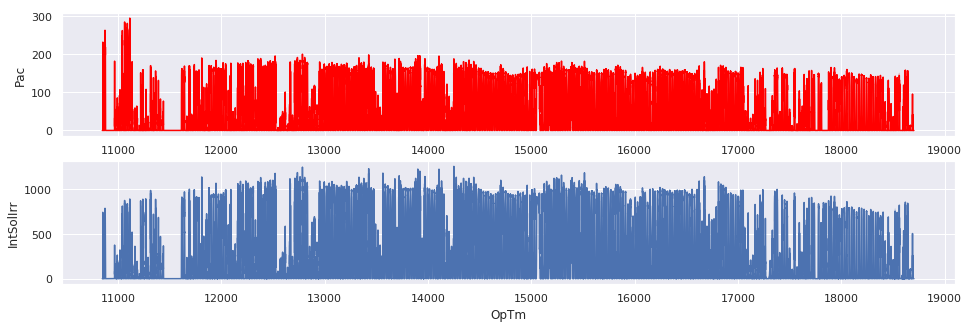

In [8]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,5))
sns.lineplot(x='OpTm', y='Pac', data=generation_data, ax=ax1, color='red'  )
sns.lineplot(x='OpTm', y='IntSolIrr', data=generation_data, ax=ax2)

**Missing data (NaN) were minimal so they were dropped**

In [9]:
def look_missings():
  missings = generation_data.isnull().sum().sort_values(ascending=False)
  print(missings)
look_missings()

Upv-Soll     2
Upv-Ist      2
Status       2
Pac          2
Netz-Ein     2
Ipv          2
h-Total      2
h-On         2
Fehler       2
TmpMdul C    1
OpTm         1
IntSolIrr    1
time         1
dtype: int64


In [10]:
generation_data.dropna(axis=0, inplace=True)
look_missings()


Upv-Soll     0
Upv-Ist      0
Status       0
Pac          0
Netz-Ein     0
Ipv          0
h-Total      0
h-On         0
Fehler       0
TmpMdul C    0
OpTm         0
IntSolIrr    0
time         0
dtype: int64


In [11]:
generation_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98076 entries, 0 to 287
Data columns (total 13 columns):
time         98076 non-null object
IntSolIrr    98076 non-null float64
OpTm         98076 non-null float64
TmpMdul C    98076 non-null float64
Fehler       98076 non-null float64
h-On         98076 non-null float64
h-Total      98076 non-null float64
Ipv          98076 non-null float64
Netz-Ein     98076 non-null float64
Pac          98076 non-null float64
Status       98076 non-null float64
Upv-Ist      98076 non-null float64
Upv-Soll     98076 non-null float64
dtypes: float64(12), object(1)
memory usage: 10.5+ MB


**The correlation analysis below points the 100% correlation between Ipv and Pac. That's because Pac is derived from Ipv, through power equation. So Ipv will be dropped to not interfere with the model prediction. Also decided to drop other columns with very low correlation.**

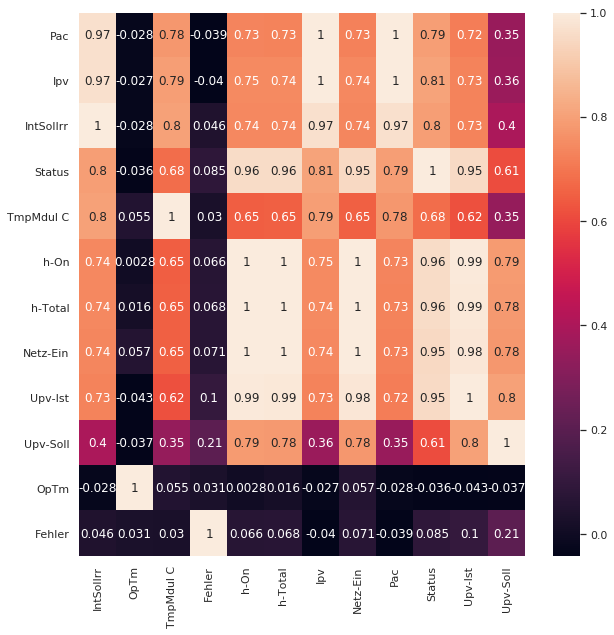

In [12]:
corr = generation_data.corr()
corr.sort_values(['Pac'], ascending = False, inplace = True)
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True )

In [0]:
generation_data.drop(['Fehler', 'Ipv', 'OpTm', 'time' ], axis=1, inplace=True)

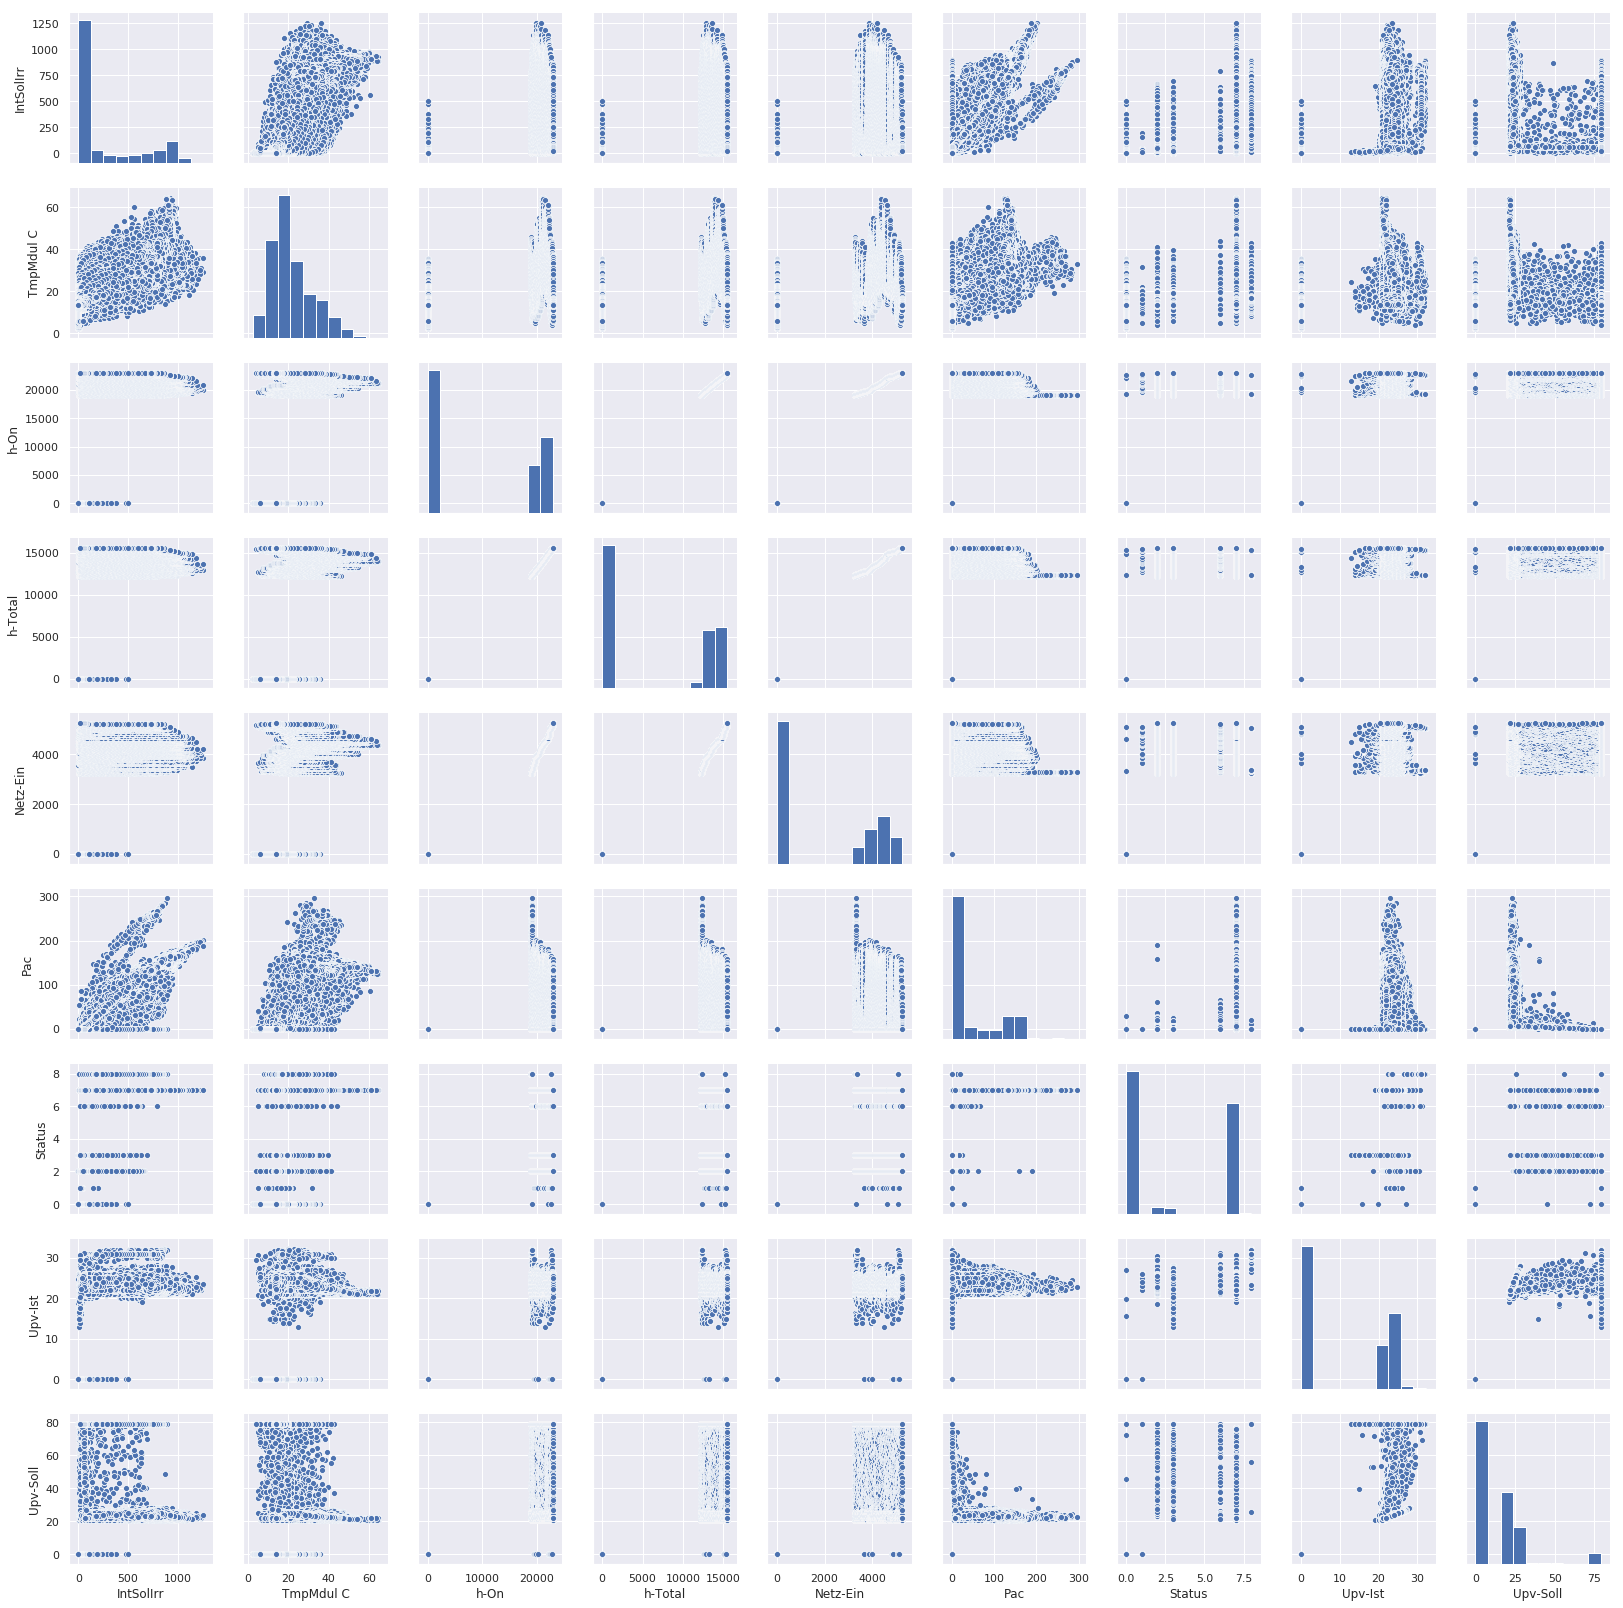

In [14]:
sns.pairplot(generation_data)

#### Step 3 - Preprocessing

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
X_transf = MinMaxScaler().fit_transform(generation_data.values) 
X = pd.DataFrame(X_transf, columns=generation_data.columns)
#X_train, X_test, y_train, y_test = train_test_split(X_norm, y, random_state=0, test_size=0.2)
y = X['Pac']
X = X.drop(['Pac'], axis=1)
X_train = X[:90000]
y_train = y[:90000]
X_test = X[90000:]
y_test = y[90000:]

#### Step 4 - Training and prediction with simple Linear Regression

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
reg = LinearRegression().fit(X_train, y_train)

In [36]:
p_train = reg.predict(X_train)
p_test = reg.predict(X_test)
RMSE_train = np.sqrt(mean_squared_error(y_train, p_train))
RMSE_test = np.sqrt(mean_squared_error(y_test, p_test))
reg_score = r2_score(y_test,p_test)
print("Training RMSE: {}\nTest RMSE: {}\nRegression score: {}".format(RMSE_train, RMSE_test, reg_score) )

Training RMSE: 0.0475081052629527
Test RMSE: 0.038333928070555835
Regression score: 0.9322128549528934


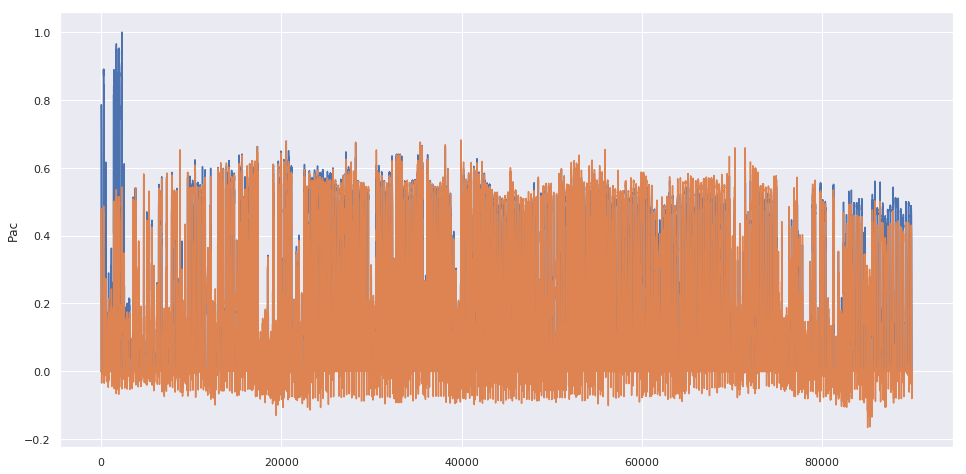

In [37]:
plt.figure(figsize=(16,8))
sns.lineplot(x=y_train.index, y=y_train)
sns.lineplot(x=y_train.index, y=p_train)

Above plot shows the average intra-day of the real Pac and predicted by linear regression. Model scored 93,2% accuracy. 

# RNN LSTM Model

The RNN are suited for sequence data , so it was implemented here a LSTM with a single step layer to evaluate its capability. It has like the name says excellent short term memory and deal well with the vanishing gradient problem. A model with multiple steps could be developed to predict even more time in the future with reasonable results considering the recent sequence of data input.

In [0]:
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.models import Sequential

In [0]:
def process_data_rnn(dataset, target, seq_length ):
  X_rnn = []
  y_rnn = []
  for i in range(seq_length, len(dataset)):
        X_rnn.append(dataset[range(i-seq_length,i)])
        y_rnn.append(target[i])
  return np.array(X_rnn), np.array(y_rnn)

In [0]:
X_train_rnn, y_train_rnn = process_data_rnn(X_train.values, y_train.values, 12)
X_test_rnn, y_test_rnn = process_data_rnn(X_test.values, y_test.values, 12)


In [0]:
#train_data_rnn = tf.data.Dataset.from_tensor_slices((X_train_rnn, y_train_rnn))
#train_data_rnn = train_data_rnn.cache().shuffle(1000).batch(12).repeat()

In [43]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=X_train_rnn.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',)
model.fit(x=X_train_rnn, y=y_train_rnn, epochs=50, batch_size=500, verbose=1)

Epoch 1/50
89988/89988 [==============================] - 9s 99us/sample - loss: 0.0084
Epoch 2/50
89988/89988 [==============================] - 7s 83us/sample - loss: 0.0033
Epoch 3/50
89988/89988 [==============================] - 7s 83us/sample - loss: 0.0030
Epoch 4/50
89988/89988 [==============================] - 8s 84us/sample - loss: 0.0028
Epoch 5/50
89988/89988 [==============================] - 8s 89us/sample - loss: 0.0027
Epoch 6/50
89988/89988 [==============================] - 8s 86us/sample - loss: 0.0025
Epoch 7/50
89988/89988 [==============================] - 8s 84us/sample - loss: 0.0024
Epoch 8/50
89988/89988 [==============================] - 8s 87us/sample - loss: 0.0022
Epoch 9/50
89988/89988 [==============================] - 8s 85us/sample - loss: 0.0022
Epoch 10/50
89988/89988 [==============================] - 8s 84us/sample - loss: 0.0021
Epoch 11/50
89988/89988 [==============================] - 8s 84us/sample - loss: 0.0022
Epoch 12/50
89988/89988 [=====

In [44]:
p_train_rnn = model.predict(X_train_rnn)
p_test_rnn = model.predict(X_test_rnn)
RMSE_train = np.sqrt(mean_squared_error(y_train_rnn, p_train_rnn))
RMSE_test = np.sqrt(mean_squared_error(y_test_rnn, p_test_rnn))
rnn_score = r2_score(y_test_rnn,p_test_rnn)
print("Training RMSE: {}\nTest RMSE: {}\n LSTM RNN score: {}".format(RMSE_train, RMSE_test, rnn_score) )

Training RMSE: 0.04101711097467319
Test RMSE: 0.037519651782670915
 LSTM RNN score: 0.9351349507184706


In [53]:
p_train_rnn_t = p_train_rnn.T


array([0.00615359, 0.00607051, 0.0060587 , ..., 0.00619806, 0.00616255,
       0.00620247], dtype=float32)

**THe LSTM shows more promissing results even with only one layer. With better tuning it should be possible to achieve even better prediction performance**

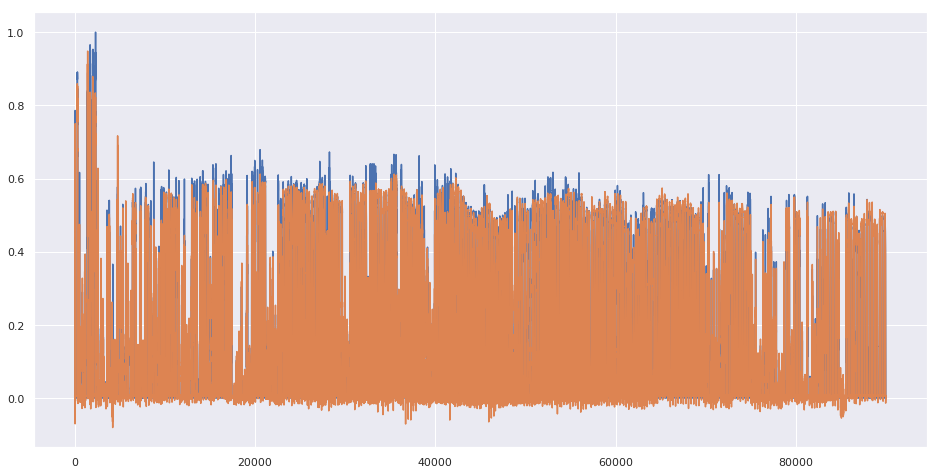

In [54]:
plt.figure(figsize=(16,8))
sns.lineplot(x=y_train.index[12:], y=y_train_rnn)
sns.lineplot(x=y_train.index[12:], y=p_train_rnn_t[0])

#### References
http://scikit-learn.org/stable/documentation.html  
https://pandas.pydata.org/pandas-docs/stable/  
https://www.tensorflow.org/api_docs   
https://jakevdp.github.io/PythonDataScienceHandbook/index.html